# **Selected Project Track**

## Project Track:
AI for Market Trend Analysis

## Sub-Domain:
Deep Learning for Time Series Forecasting

## Application Area:
Financial Technology (FinTech)

# **Clear Problem Statement**

*Can a Transformer-based attention model, trained on historical stock price data, accurately learn temporal patterns and generate reliable short-term future price predictions while maintaining robustness through walk-forward validation?*

### The problem is framed as a supervised regression task, where:

Input: Sliding windows of historical closing prices

Output: Future closing price predictions

# **Real-World Relevance and Motivation**

## Accurate stock price forecasting is critical for:

* Investment decision-making
* Portfolio management
* Risk analysis

## Traditional statistical models often fail due to:

* Linear assumptions
* Limited capacity to model long-range dependencies

##Transformer models overcome these limitations by:

* Utilizing self-attention mechanisms
* Capturing global temporal relationships
* Enabling parallel sequence processing

This motivates the adoption of Transformer-based architectures for financial forecasting.

# **Data Understanding & Preparation**

### Data Source
- Yahoo Finance via `yfinance`
- Daily stock closing prices
- 10-year historical window

### Preprocessing Steps
- Selection of closing price as the primary feature  
- Handling missing values  
- Min-Max normalization  
- Conversion of time-series data into supervised learning sequences using a rolling window approach  

### Validation Strategy
- Walk-forward validation to simulate real-world deployment conditions  
- Sequential retraining to avoid look-ahead bias  


# **Model / System Design**

### Architecture Overview
The system uses a **Transformer encoder architecture** composed of:
- Multi-Head Self-Attention layers  
- Feed-Forward neural networks  
- Residual connections  
- Layer normalization  

### Key Design Advantages
- Captures long-term dependencies efficiently  
- Avoids vanishing gradient issues common in RNNs  
- Enables scalable and parallelizable training  


# Core Implementation

### Model Training
- The Transformer model is trained using historical sequences  
- Walk-forward validation retrains the model iteratively  
- Final training is performed on the full dataset  

### Prediction Mechanism
- Recursive multi-step forecasting  
- Uses last observed sequence to predict future values  
- Generates a 30-day forecast starting from the current date  

# Evaluation & Analysis

### Evaluation Techniques
- Root Mean Squared Error (RMSE)  
- Visual comparison of predicted vs actual prices  
- Walk-forward backtesting results  

### Observations
- The model captures overall price trends effectively  
- Short-term forecasts demonstrate higher accuracy  
- Performance degrades during high-volatility market periods

### Limitations
- Relies solely on historical price data  
- Does not incorporate news sentiment or macroeconomic indicators  

# Ethical Considerations & Responsible AI

### Financial Risk Awareness
Stock price predictions can influence financial decisions and may lead to losses if misused.

### Responsible Usage
- The model is designed for educational and analytical purposes only  
- Not intended as financial advice  

### Transparency & Bias
- Model behavior is dependent on historical data  
- Unforeseen market events cannot be predicted  

Clear disclaimers are necessary to ensure ethical usage.

# IMPORT REQUIRED LIBRARIES

In [13]:
pip install numpy pandas matplotlib yfinance scikit-learn tensorflow

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    LayerNormalization,
    MultiHeadAttention,
    Add
)

import warnings
warnings.filterwarnings("ignore")

# GLOBAL CONFIGURATION

In [40]:
TICKER = "AAPL"                  # Stock ticker
HISTORICAL_PERIOD = "10y"        # Historical data duration
SEQUENCE_LENGTH = 60             # Lookback window
FUTURE_DAYS = 30                 # Forecast horizon
EPOCHS = 100                      # Training epochs
BATCH_SIZE = 32                  # Batch size
NUM_HEADS = 4                    # Transformer attention heads
KEY_DIM = 32                     # Attention key dimension
FF_DIM = 128                     # Feed-forward network dimension

# DATA COLLECTION

In [41]:
data = yf.download(TICKER, period=HISTORICAL_PERIOD)
data = data[['Close']]
data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


# INSPECT COLLECTED DATA

In [42]:
# Display the first few rows of the dataset
print("FIRST 5 ROWS OF THE DATASET:")
display(data.head())

# Display the last few rows of the dataset
print("\nLAST 5 ROWS OF THE DATASET:")
display(data.tail())

FIRST 5 ROWS OF THE DATASET:


Price,Close
Ticker,AAPL
Date,
2016-01-19,21.793827
2016-01-20,21.823133
2016-01-21,21.712654
2016-01-22,22.867062
2016-01-25,22.420628



LAST 5 ROWS OF THE DATASET:


Price,Close
Ticker,AAPL
Date,
2026-01-12,260.250000
2026-01-13,261.049988
2026-01-14,259.959991
2026-01-15,258.209991
2026-01-16,255.529999


In [43]:
# Display dataset information (columns, data types, non-null counts)
print("\nDATASET INFORMATION:")
data.info()


DATASET INFORMATION:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2016-01-19 to 2026-01-16
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, AAPL)  2515 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [44]:
# Display descriptive statistics of the closing prices
print("\nDESCRIPTIVE STATISTICS:")
display(data.describe())


DESCRIPTIVE STATISTICS:


Price,Close
Ticker,AAPL
count,2515.000000
mean,115.299898
std,73.744273
min,20.604080
25%,41.781998
50%,121.629379
75%,172.103455
max,286.190002


# VISUALIZE HISTORICAL CLOSING PRICE

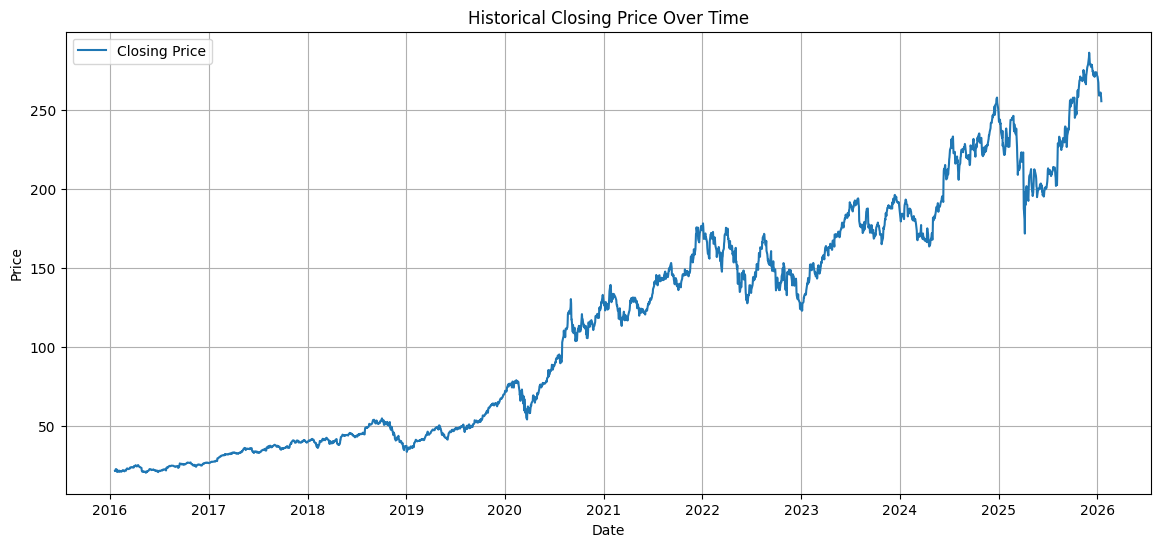

In [45]:
plt.figure(figsize=(14, 6))
plt.plot(data.index, data['Close'], label="Closing Price")
plt.title("Historical Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()


In [46]:
#CHECK FOR MISSING VALUES
print("\nMISSING VALUES CHECK:")
display(data.isnull().sum())


MISSING VALUES CHECK:


,,0
Price,Ticker,
Close,AAPL,0


# DATA SCALING

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data.values)

# SEQUENCE GENERATION

In [23]:
def create_sequences(dataset, sequence_length):
    X, y = [], []
    for i in range(sequence_length, len(dataset)):
        X.append(dataset[i-sequence_length:i])
        y.append(dataset[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

# WALK-FORWARD VALIDATION SPLITS

In [24]:
def walk_forward_split(X, y, train_size):
    """
    Generates train-test splits for walk-forward validation
    """
    X_train = X[:train_size]
    y_train = y[:train_size]
    X_test = X[train_size:train_size+1]
    y_test = y[train_size:train_size+1]
    return X_train, y_train, X_test, y_test

# TRANSFORMER BLOCK DEFINITION

In [25]:
def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
    """
    Single Transformer encoder block
    """
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=key_dim
    )(inputs, inputs)

    attention_output = Dropout(dropout)(attention_output)
    out1 = Add()([inputs, attention_output])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ff_output = Dense(ff_dim, activation="relu")(out1)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout)(ff_output)

    out2 = Add()([out1, ff_output])
    return LayerNormalization(epsilon=1e-6)(out2)

# TRANSFORMER MODEL DEFINITION

In [26]:
def build_transformer_model():
    """
    Transformer-based time series forecasting model
    """
    inputs = Input(shape=(SEQUENCE_LENGTH, 1))
    x = transformer_block(inputs, NUM_HEADS, KEY_DIM, FF_DIM)
    x = transformer_block(x, NUM_HEADS, KEY_DIM, FF_DIM)
    x = tf.keras.layers.Flatten()(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1)(x)

    model = Model(inputs, outputs)
    model.compile(
        optimizer="adam",
        loss="mse"
    )
    return model

# BACKTESTING WITH WALK-FORWARD VALIDATION

In [27]:
walk_forward_predictions = []
walk_forward_actuals = []

initial_train_size = int(0.8 * len(X))

print(f"Total samples        : {len(X)}")
print(f"Initial train size   : {initial_train_size}")
print(f"Walk-forward steps   : {len(X) - initial_train_size - 1}")
print("-" * 70)

for i in range(initial_train_size, len(X) - 1):

    print(f"\n🔁 Walk-Forward Step {i - initial_train_size + 1}")
    print(f"Training samples    : {i}")
    print(f"Testing index       : {i}")

    # Create train-test split for current step
    X_train, y_train, X_test, y_test = walk_forward_split(X, y, i)

    # Reshape for Transformer input
    X_train = X_train.reshape((X_train.shape[0], SEQUENCE_LENGTH, 1))
    X_test = X_test.reshape((X_test.shape[0], SEQUENCE_LENGTH, 1))

    # Build a fresh Transformer model (prevents data leakage)
    model = build_transformer_model()

    # Train model
    print("Training model...")
    model.fit(
        X_train,
        y_train,
        epochs=1,
        batch_size=BATCH_SIZE,
        verbose=0
    )

    # Make prediction
    prediction = model.predict(X_test, verbose=0)

    # Store results
    walk_forward_predictions.append(prediction[0][0])
    walk_forward_actuals.append(y_test[0][0])

    # Display prediction vs actual
    predicted_price = scaler.inverse_transform([[prediction[0][0]]])[0][0]
    actual_price = scaler.inverse_transform([[y_test[0][0]]])[0][0]

    print(f"Predicted Price     : {predicted_price:.2f}")
    print(f"Actual Price        : {actual_price:.2f}")
    print("-" * 50)


Total samples        : 244
Initial train size   : 195
Walk-forward steps   : 48
----------------------------------------------------------------------

🔁 Walk-Forward Step 1
Training samples    : 195
Testing index       : 195
Training model...
Predicted Price     : 172.63
Actual Price        : 269.51
--------------------------------------------------

🔁 Walk-Forward Step 2
Training samples    : 196
Testing index       : 196
Training model...
Predicted Price     : 172.63
Actual Price        : 268.21
--------------------------------------------------

🔁 Walk-Forward Step 3
Training samples    : 197
Testing index       : 197
Training model...
Predicted Price     : 172.63
Actual Price        : 269.43
--------------------------------------------------

🔁 Walk-Forward Step 4
Training samples    : 198
Testing index       : 198
Training model...
Predicted Price     : 172.63
Actual Price        : 275.25
--------------------------------------------------

🔁 Walk-Forward Step 5
Training samples  

Predicted Price     : 172.63
Actual Price        : 273.47
--------------------------------------------------

🔁 Walk-Forward Step 6
Training samples    : 200
Testing index       : 200
Training model...


Predicted Price     : 172.63
Actual Price        : 272.95
--------------------------------------------------

🔁 Walk-Forward Step 7
Training samples    : 201
Testing index       : 201
Training model...
Predicted Price     : 172.63
Actual Price        : 272.41
--------------------------------------------------

🔁 Walk-Forward Step 8
Training samples    : 202
Testing index       : 202
Training model...
Predicted Price     : 172.63
Actual Price        : 267.46
--------------------------------------------------

🔁 Walk-Forward Step 9
Training samples    : 203
Testing index       : 203
Training model...
Predicted Price     : 172.63
Actual Price        : 267.44
--------------------------------------------------

🔁 Walk-Forward Step 10
Training samples    : 204
Testing index       : 204
Training model...
Predicted Price     : 172.63
Actual Price        : 268.56
--------------------------------------------------

🔁 Walk-Forward Step 11
Training samples    : 205
Testing index       : 205
Traini

In [28]:
# Inverse scaling
walk_forward_predictions = scaler.inverse_transform(
    np.array(walk_forward_predictions).reshape(-1, 1)
)
walk_forward_actuals = scaler.inverse_transform(
    np.array(walk_forward_actuals).reshape(-1, 1)
)

# BACKTESTING EVALUATION

In [29]:
rmse_walk_forward = np.sqrt(
    mean_squared_error(walk_forward_actuals, walk_forward_predictions)
)

print("WALK-FORWARD VALIDATION RMSE:", rmse_walk_forward)

WALK-FORWARD VALIDATION RMSE: 99.42223219040497


# FINAL TRAINING ON FULL DATASET

In [30]:
X_full = X.reshape((X.shape[0], SEQUENCE_LENGTH, 1))
y_full = y

final_model = build_transformer_model()
final_model.fit(
    X_full,
    y_full,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.3381
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3548
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3176
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3192
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3056
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3014
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3073
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2730
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2629
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2827


# NEXT 30 DAYS FORECAST FROM TODAY

In [31]:
last_sequence = scaled_data[-SEQUENCE_LENGTH:].reshape(1, SEQUENCE_LENGTH, 1)
future_predictions = []

for _ in range(FUTURE_DAYS):
    next_price = final_model.predict(last_sequence, verbose=0)[0][0]
    future_predictions.append(next_price)
    last_sequence = np.append(
        last_sequence[:, 1:, :],
        [[[next_price]]],
        axis=1
    )

future_predictions = scaler.inverse_transform(
    np.array(future_predictions).reshape(-1, 1)
)

future_dates = pd.date_range(
    start=pd.Timestamp.today(),
    periods=FUTURE_DAYS,
    freq="B"
)

future_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted Closing Price": future_predictions.flatten()
})

# VISUALIZATION

In [32]:
plt.figure(figsize=(15, 7))

<Figure size 1500x700 with 0 Axes>

<Figure size 1500x700 with 0 Axes>

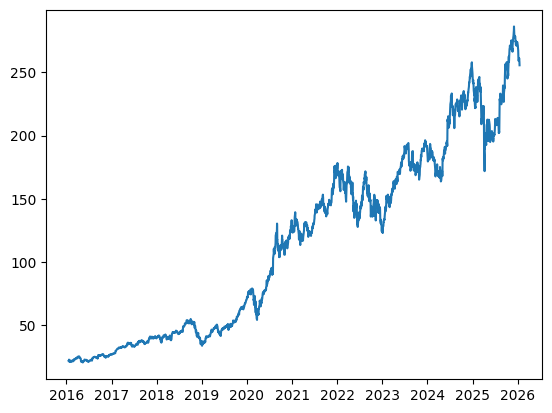

In [48]:
# Historical prices

plt.plot(data.index, data['Close'], label="Historical Prices")

# FINAL OUTPUT





In [38]:
print("\nNEXT 30 DAYS STOCK PRICE FORECAST:")
print(future_df)


NEXT 30 DAYS STOCK PRICE FORECAST:
                         Date  Predicted Closing Price
0  2026-01-16 22:50:22.611819               261.009443
1  2026-01-19 22:50:22.611819               267.368807
2  2026-01-20 22:50:22.611819               278.945047
3  2026-01-21 22:50:22.611819               267.483526
4  2026-01-22 22:50:22.611819               279.281293
5  2026-01-23 22:50:22.611819               278.269698
6  2026-01-26 22:50:22.611819               274.656338
7  2026-01-27 22:50:22.611819               264.721662
8  2026-01-28 22:50:22.611819               261.474811
9  2026-01-29 22:50:22.611819               266.880526
10 2026-01-30 22:50:22.611819               263.145852
11 2026-02-02 22:50:22.611819               276.927404
12 2026-02-03 22:50:22.611819               272.052354
13 2026-02-04 22:50:22.611819               275.100732
14 2026-02-05 22:50:22.611819               270.626544
15 2026-02-06 22:50:22.611819               273.195965
16 2026-02-09 22:50:22.611819

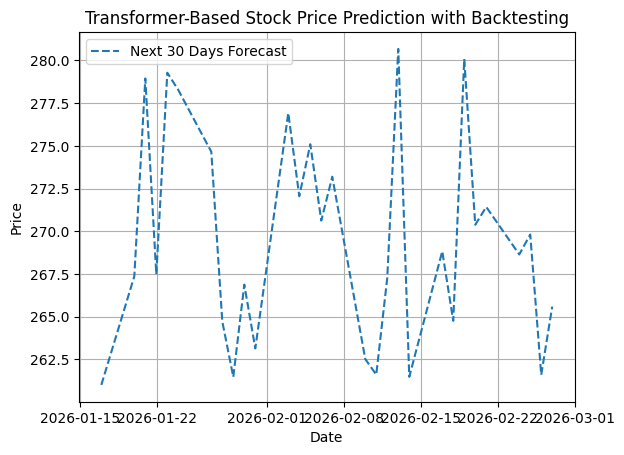

In [39]:
# Future predictions

plt.plot(
    future_df['Date'],
    future_df['Predicted Closing Price'],
    label="Next 30 Days Forecast",
    linestyle="dashed"
)

plt.title("Transformer-Based Stock Price Prediction with Backtesting")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

# Conclusion & Future Scope

### Conclusion
This project demonstrates the effectiveness of **Transformer-based attention models** in financial time-series forecasting. By integrating **walk-forward validation and backtesting**, the system provides a realistic and robust prediction framework capable of generating meaningful short-term forecasts.

### Future Enhancements
- Integration of news and sentiment analysis  
- Inclusion of macroeconomic indicators  
- Use of probabilistic forecasting methods  
- Deployment as a real-time prediction service  
- Exploration of hybrid Transformer–LSTM architectures  